In [ ]:
#| default_exp modules

In [ ]:
#| hide
from nbdev.showdoc import *

# modules

> This package contains the modules that make up the [FastSpeech](https://arxiv.org/abs/1905.09263) architecture
![](../assets/fastspeech-architecture.png)

In [ ]:
#| export
import torch
import torch.nn as nn
from torch import tensor
from math import sqrt
import torch.nn.functional as F

In [ ]:
#| hide
from fastcore.test import *
import matplotlib.pyplot as plt
import librosa
from fastspeech.visualize import show_mel

In [ ]:
#| hide
def get_shape(*args: tensor): return tuple(map(lambda x: x.shape, [*args]))

In [ ]:
#| hide

vocab_sz = 50
n_hidden = 48
filter_sz = 64
n_heads = 2
bs = 16
seq_len = 18
out_shape = [bs, seq_len, n_hidden]

In [ ]:
#| hide
sample_batch = torch.randint(vocab_sz, (bs, seq_len))
sample_batch.shape

torch.Size([16, 18])

## phoneme embedding
> The first module of the fastspeech architecture is the input embeddings where they embed the input phonemes in to the models hidden dimension

In [ ]:
embedding = nn.Embedding(vocab_sz, n_hidden)
samples_embedded = embedding(sample_batch)
samples_embedded.shape

torch.Size([16, 18, 48])

In [ ]:
#| hide
test_eq(out_shape, samples_embedded.shape)

## positional embedding
> After the embedding layer in the fastspeech model it inputs positional embedding to allow the model to have information on the positons of inputs. The positional embedding used in the [FastSpeech](https://arxiv.org/abs/1905.09263) paper is the function described in the [Attention Is All You Need](https://arxiv.org/abs/1706.03762) paper.

In [ ]:
#| export
def get_positional_embeddings(seq_len, # The length of the sequence
                              d_model, # The hidden dimension of the model
                              device: torch.device =None): # Device you want to use
    pos = torch.arange(d_model, device=device)[None, :]
    i = torch.arange(seq_len, device=device)[:, None]
    angle = pos / torch.pow(10000, 2 * i / d_model)
    pos_emb = torch.zeros(angle.shape, device=device)
    pos_emb[0::2,:], pos_emb[1::2,:] = angle[0::2,:].sin(), angle[1::2,:].cos()
    return pos_emb

In [ ]:
pos_emb = get_positional_embeddings(seq_len, n_hidden)
pos_emb.shape

torch.Size([18, 48])

In [ ]:
#| hide
test_eq(pos_emb.shape, [seq_len, n_hidden])

In [ ]:
inp = samples_embedded + pos_emb
inp.shape

torch.Size([16, 18, 48])

In [ ]:
#| hide
test_eq(inp.shape, out_shape)

## xavier initialization

In [ ]:
#| export
class Conv1d(nn.Conv1d):
    ''''''
    def __init__(self, *args, gain="linear", **kwargs):
        ''''''
        super().__init__(*args, **kwargs)
        nn.init.xavier_uniform_(self.weight, nn.init.calculate_gain(gain))

In [ ]:
Conv1d(seq_len, 10, 1)(inp).shape

torch.Size([16, 10, 48])

In [ ]:
#| export
class Linear(nn.Linear):
    ''''''
    def __init__(self, *args, gain="linear", **kwargs):
        ''''''
        super().__init__(*args, **kwargs)
        nn.init.xavier_uniform_(self.weight, nn.init.calculate_gain(gain))

## feed-forward transformer
> This component of the model is the engine of the model. It is what will be used to make up the phoneme encoder and mel spectrogram decoder. It consists of a Multi-Head Attention block and a Conv Network. An additional note from the paper is that prior to the addition of residual inputs and the normalization. ![Scaled Dot Product Attention and Multi-Head Attention](../assets/multi-head-attention.png)

In [ ]:
#| export
def scaled_dot_product_attention(query, key, value):
    dim_k = query.size(-1)
    scores = query@key.transpose(1,2) / sqrt(dim_k)
    weights = F.softmax(scores, dim=-1)
    return weights@value

In [ ]:
t1 = torch.randn((1,24,32))
scaled_dot_product_attention(t1,t1,t1).shape

torch.Size([1, 24, 32])

In [ ]:
#| export
class AttentionHead(nn.Module):
    ''''''
    def __init__(self, embed_dim, head_dim):
        ''''''
        super().__init__()
        self.qkv = nn.Linear(embed_dim, head_dim*3)
    
    def forward(self, hidden_state):
        q, k, v = torch.chunk(self.qkv(hidden_state), 3, dim=-1)
        attn_outputs = scaled_dot_product_attention(q, k, v)
        return attn_outputs

In [ ]:
AttentionHead(32, 16)(t1).shape

torch.Size([1, 24, 16])

In [ ]:
#| export
class MultiHeadAttention(nn.Module):
    ''''''
    def __init__(self, config):
        ''''''
        super().__init__()
        embed_dim, num_heads, p = (config["hidden_size"], config["num_attention_heads"],
                                   config["hidden_dropout_prob"])
        head_dim = embed_dim // num_heads
        self.heads = nn.ModuleList([AttentionHead(embed_dim, head_dim) 
                                    for _ in range(num_heads)])
        self.linear = nn.Linear(embed_dim, embed_dim)
        self.dropout = nn.Dropout(p)
    def forward(self, hidden_states):
        x = torch.cat([h(hidden_states) for h in self.heads], dim=-1)
        x = self.linear(x)
        x = self.dropout(x)
        return x

In [ ]:
config = {"hidden_size": 32, "num_attention_heads": 4, "hidden_dropout_prob": 0.1}
MultiHeadAttention(config)(t1).shape

torch.Size([1, 24, 32])

In [ ]:
#| export
class ConvNet(nn.Module):
    ''''''
    def __init__(self, config):
        ''''''
        super().__init__()
        hs, ks, fs, p = (config["hidden_size"], config["kernal_sizes"], config["filter_size"],
                         config["hidden_dropout_prob"])
        assert len(ks) == 2
        padding = list(map(lambda x: (x - 1) // 2, ks))
        self.conv1 = Conv1d(hs, fs, ks[0], padding=padding[0], gain="relu")
        self.conv2 = Conv1d(fs, hs, ks[1], padding=padding[1], gain="relu")
        self.dropout = nn.Dropout(p)

    def forward(self, x):
        x = self.conv1(x.transpose(1,2))
        x = F.relu(x)
        x = self.conv2(x)
#         x = F.relu(x)
        x = self.dropout(x)
        return x.transpose(1, 2)

In [ ]:
config = {"hidden_size": 32, "kernal_sizes": [3,3], "filter_size": 16,
          "hidden_dropout_prob": 0.1}
ConvNet(config)(t1).shape

torch.Size([1, 24, 32])

In [ ]:
#| export
class FeedForwardTransformer(nn.Module):
    ''''''
    def __init__(self, config):
        ''''''
        super().__init__()
        self.layer_norm1 = nn.LayerNorm(config["hidden_size"])
        self.layer_norm2 = nn.LayerNorm(config["hidden_size"])
        self.attention = MultiHeadAttention(config["multi_head_attention"])
        self.conv_net = ConvNet(config["conv_net"])
    
    def forward(self, x):
        x = self.layer_norm1(x + self.attention(x))
        x = self.layer_norm1(x + self.conv_net(x))
        return x

In [ ]:
config = {
    "hidden_size": 32,
    "multi_head_attention": {"hidden_size": 32, "num_attention_heads": 4, 
                             "hidden_dropout_prob": 0.1},
    "conv_net": {"hidden_size": 32, "kernal_sizes": [3,3], "filter_size": 16,
                 "hidden_dropout_prob": 0.1}
}
FeedForwardTransformer(config)(t1).shape

torch.Size([1, 24, 32])

## duration predictor

In [ ]:
#| export
class DurationPredictor(nn.Module):
    '''This module predicts the logarithmic duration length for each phoneme 
    based on the phoneme hidden features. It consists of 2-layer 1D convolutional network 
    with ReLU activation, each followed by the layer normalization and the dropout layer, 
    and an extra linear layer to output a scalar.'''
    def __init__(self, config):
        ''''''
        super().__init__()
        hs, ks, fs, p = (config["hidden_size"], config["kernal_sizes"], 
                         config["filter_size"], config["hidden_dropout_prob"])
        assert len(ks) == 2
        
        padding = list(map(lambda x: (x - 1) // 2, ks))
        self.layers = nn.ModuleList([Conv1d(hs, fs, ks[0], padding=padding[0], gain="relu"),
                                     Conv1d(fs, hs, ks[1], padding=padding[1], gain="relu")])
        self.norms = nn.ModuleList([nn.LayerNorm(sz) for sz in [fs, hs]])
        self.dropout = nn.Dropout(p)
        self.linear = Linear(hs, 1)
    
    def forward(self, x):
        modules = zip(self.layers, self.norms)
        for layer, norm in modules:
            x = F.relu(layer(x.transpose(1,2)))
            x = self.dropout(F.relu(x))
            x = norm(x.transpose(1,2))
        x = self.linear(x)
        return x.squeeze()

In [ ]:
config = {"hidden_size": 32, "kernal_sizes": [3,3], "filter_size": 16, 
          "hidden_dropout_prob": 0.1}
log_durations = DurationPredictor(config)(torch.randn((3,18,32)))
log_durations.shape

torch.Size([3, 18])

## length regulator
> This module upsamples the phoneme hidden feature to the size of the melspectrogram based on the phoneme durations provided

In [ ]:
#| export
def length_regulator(hi: tensor, # The hidden phoneme features
                     durations: tensor, # The phoneme durations to upsample to
                     upsample_ratio: float, # The multiplier ratio of upsampling rate
                     device: torch.device = None): # Device you want to use
    assert len(durations.sum(dim=1).unique()) == 1
    durations = (upsample_ratio * durations).to(torch.int)
    
    (bs, _, nh), sl = hi.shape, durations[0].sum().item()
    
    ho = torch.zeros((bs, sl, nh), device=device)
    for i in range(bs):
        ho[i] = hi[i].repeat_interleave(durations[i], dim=0)
    return ho

## postnet
> To help convergence we use a postenet as described in [tacotron 2](https://arxiv.org/abs/1712.05884)

In [ ]:
#| export
class PostNet(nn.Module):
    def __init__(self, config): 
        super().__init__()
        hs, ks, fs, p, nl = (config["hidden_size"], config["kernal_size"], 
                             config["filter_size"], config["hidden_dropout_prob"], config["num_layers"])
        padding = (ks - 1) // 2
        self.layers = nn.ModuleList([Conv1d(hs, fs, ks, padding=padding),
                                   *[Conv1d(fs, fs, ks, padding=padding) 
                                       for i in range(nl-2)],
                                     Conv1d(fs, hs, ks, padding=padding)])
        self.norms = nn.ModuleList([*[nn.BatchNorm1d(fs) for i in range(nl-1)],
                                     nn.BatchNorm1d(hs)])
        self.dropout = nn.Dropout(p)
        
    def forward(self, inp):
        x = inp
        
        modules = zip(self.layers, self.norms)
        for i, (layer, norm) in enumerate(modules):
            x = layer(x)
            x = norm(x)
            x = F.tanh(x) if i < len(self.layers) - 1 else x
            x = self.dropout(x)
            
        return x

In [ ]:
config = {"hidden_size": 32, "kernal_size": 3, "filter_size": 16, "hidden_dropout_prob": 0.1, "num_layers": 5}
PostNet(config)(t1.transpose(1,2)).shape

torch.Size([1, 32, 24])

## fastspeech
> This is module will contain the full architecture for FastSpeech. it will consists of the feed-forward Transformer block, the length regulator, and the duration predictor.

In [ ]:
#| export
class FastSpeech(nn.Module):
    ''''''
    def __init__(self, config, device=None):
        ''''''
        super().__init__()
        self.device = device
        es, hs, no, ne, nd = (config["embedding_size"], config["hidden_size"], config["num_bins"], 
                              config["num_encoders"], config["num_decoders"])
        self.embedding = nn.Embedding(es, hs)
        self.encoder = nn.Sequential(*[FeedForwardTransformer(config["encoder"]) for _ in range(ne)])
        self.decoder = nn.Sequential(*[FeedForwardTransformer(config["decoder"]) for _ in range(nd)])
        self.duration_predictor = DurationPredictor(config["duration_predictor"])
        self.linear = Linear(hs, no)
#         self.postnet = PostNet(config["postnet"])
        
    def forward(self, phones, durations=None, upsample_ratio=1.):
        x = self.embedding(phones)
        x = x +  get_positional_embeddings(*x.shape[-2:], device=self.device)
        x = self.encoder(x)

        log_durations = self.duration_predictor(x.detach())
        if durations == None or not self.training:
            durations = log_durations.exp()
        x = length_regulator(x, durations, upsample_ratio, device=self.device)
        
        x = x + get_positional_embeddings(*x.shape[-2:], device=self.device)
        x = self.decoder(x)
        x = self.linear(x).transpose(1,2)
        
#         res = self.postnet(x)
#         x = (x + res)
        
#         return (x, log_durations, res) if self.training else x   
        return (x, log_durations) if self.training else x   

In [ ]:
#| hide
durations = tensor([[10]*seq_len for i in range(bs)])

In [ ]:
config = {
    "embedding_size": 85, "hidden_size": 32, "num_bins": 80, "num_encoders": 2, "num_decoders": 2,
    "encoder": {
        "hidden_size": 32,
        "multi_head_attention": {"hidden_size": 32, "num_attention_heads": 4, 
                                 "hidden_dropout_prob": 0.1},
        "conv_net": {"hidden_size": 32, "kernal_sizes": [3,3], "filter_size": 16,
                     "hidden_dropout_prob": 0.1}
    },
    "decoder": {
        "hidden_size": 32,
        "multi_head_attention": {"hidden_size": 32, "num_attention_heads": 4,
                                "hidden_dropout_prob": 0.1},
        "conv_net": {"hidden_size": 32, "kernal_sizes": [3,3], "filter_size": 16,
                     "hidden_dropout_prob": 0.1}
    },
    "duration_predictor": {"hidden_size": 32, "kernal_sizes": [3,3], "filter_size": 16, "hidden_dropout_prob": 0.1},
    "postnet": {"hidden_size": 80, "kernal_size": 3, "filter_size": 16, "hidden_dropout_prob": 0.1, "num_layers": 5},
}
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = FastSpeech(config, device=device).to(device)
with torch.no_grad(): mel, _ = model(sample_batch.to(device), durations.to(device))
mel.shape

torch.Size([16, 80, 180])

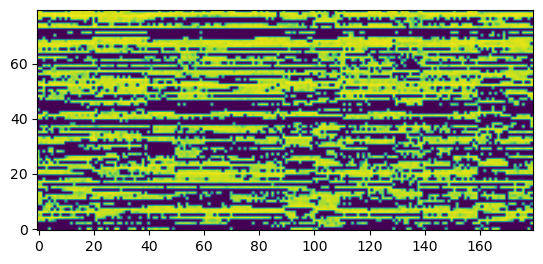

In [ ]:
show_mel(mel[0].cpu());

In [ ]:
#| hide
import nbdev; nbdev.nbdev_export()